# 0.0 IMPORTS

In [65]:
import pandas as pd
import numpy as np
import inflection
import os
import seaborn as sns
import matplotlib.pyplot as plt 

from datetime import datetime, timedelta
from sklearn import model_selection as ms
from sklearn import metrics as mt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

## 0.1 Loading Data

In [2]:
path = 'C:/Users/edils/repos/leilao_fechamento/data/5_minutos/'

In [3]:
df_raw_list = []

for file in os.listdir(path):
    if file.endswith('.csv'):
        filename_path = os.path.join(path, file)
        df = pd.read_csv(filename_path, encoding='iso-8859-1', sep=';')
        df_raw_list.append(df)

In [4]:
df_raw = pd.concat(df_raw_list, axis=0)

In [5]:
df_raw.head()

,Ativo,Data,Hora,Abertura,Máximo,Mínimo,Fechamento,Volume,Quantidade
0,AALR3,22/05/2023,13:55:00,"22,63","22,63","22,63","22,63","2.263,00",100.0
1,AALR3,22/05/2023,13:50:00,"22,63","22,63","22,62","22,62","6.788,00",300.0
2,AALR3,22/05/2023,13:45:00,"22,63","22,63","22,62","22,62","9.050,00",400.0
3,AALR3,22/05/2023,13:40:00,"22,63","22,63","22,63","22,63","2.263,00",100.0
4,AALR3,22/05/2023,13:35:00,"22,63","22,63","22,62","22,63","6.788,00",300.0


## 0.4 Helper Functions

In [7]:
def data_types(df1):
    #abertura
    df1['abertura'] = df1['abertura'].apply(lambda x: x.replace(',','.'))
    df1['abertura'] = df1['abertura'].astype(float)

    #maximo
    df1['maximo'] = df1['maximo'].apply(lambda x: x.replace(',','.'))
    df1['maximo'] = df1['maximo'].astype(float)

    #minimo
    df1['minimo'] = df1['minimo'].apply(lambda x: x.replace(',','.'))
    df1['minimo'] = df1['minimo'].astype(float)

    #fechamento
    df1['fechamento'] = df1['fechamento'].apply(lambda x: x.replace(',','.'))
    df1['fechamento'] = df1['fechamento'].astype(float)

    #volume
    df1['volume'] = df1['volume'].apply(lambda x: x.replace(".", "").replace(",", "."))
    df1['volume'] = df1['volume'].astype(float)

    #quantidade
    df1['quantidade'] = df1['quantidade'].apply(lambda x: x.replace(".", "") if isinstance(x, str) else x)
    df1['quantidade'] = df1['quantidade'].apply(lambda x: float(x))

    #data
    df1['data'] = df1['data'].apply(lambda x: x.replace('/','-'))
    df1['data'] = df1['data'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    df1['data'] = pd.to_datetime(df1['data'], format='%d-%m-%Y')
    df1['hora'] = df1['hora'].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))
    
    return df1

def rename_columns(df1):
    cols_old = df1.columns
    cols_new = cols_old.map(lambda x: inflection.underscore(x))
    df1.columns = cols_new
    df1 = df1.rename(columns={'máximo': 'maximo', 'mínimo':'minimo'})
    
    return df1

def horario_verao(df1):
    #Horário de verão 2023-03-13
    data_verao = pd.to_datetime('2023-03-13')
    df1.loc[df1['data'] >= data_verao, 'hora'] += pd.Timedelta(hours=1)
    return df1

def clean_futuros(df_win):
    cols_old = df_win.columns
    cols_new = cols_old.map(lambda x: inflection.underscore(x))
    df_win.columns = cols_new
    df_win = df_win.rename(columns={'máximo': 'maximo', 'mínimo':'minimo'})

    df_win['abertura'] = df_win['abertura'].astype(float)

    #maximo

    df_win['maximo'] = df_win['maximo'].astype(float)

    #minimo

    df_win['minimo'] = df_win['minimo'].astype(float)

    #fechamento

    df_win['fechamento'] = df_win['fechamento'].astype(float)

    #volume
    df_win['volume'] = df_win['volume'].apply(lambda x: x.replace(".", "").replace(",", "."))
    df_win['volume'] = df_win['volume'].astype(float)

    #quantidade
    df_win['quantidade'] = df_win['quantidade'].apply(lambda x: x.replace(".", "") if isinstance(x, str) else x)
    df_win['quantidade'] = df_win['quantidade'].apply(lambda x: float(x))

    #data
    df_win['data'] = df_win['data'].apply(lambda x: x.replace('/','-'))
    df_win['data'] = df_win['data'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    df_win['data'] = pd.to_datetime(df_win['data'], format='%d-%m-%Y')
    df_win['hora'] = df_win['hora'].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))
    df_win['variacao'] = (df_win['fechamento'] - df_win['abertura']) / df_win['abertura']
    
    #Horário de verão 2023-03-13
    data_verao = pd.to_datetime('2023-03-13')
    df_win.loc[df_win['data'] >= data_verao, 'hora'] += pd.Timedelta(hours=1)
    
    hora_leilao = (df_win['hora'].dt.hour >= 16) & (df_win['hora'].dt.hour < 18) 
    df_win = df_win.loc[hora_leilao,:]
    
    df_win['variacao'] = (df_win['fechamento'] - df_win['abertura']) / df_win['abertura']
    
    return df_win

# 1.0 DATA DESCRIPTION

In [8]:
df1 = df_raw.copy()

In [9]:
df1

,Ativo,Data,Hora,Abertura,Máximo,Mínimo,Fechamento,Volume,Quantidade
0,AALR3,22/05/2023,13:55:00,"22,63","22,63","22,63","22,63","2.263,00",100.0
1,AALR3,22/05/2023,13:50:00,"22,63","22,63","22,62","22,62","6.788,00",300.0
2,AALR3,22/05/2023,13:45:00,"22,63","22,63","22,62","22,62","9.050,00",400.0
3,AALR3,22/05/2023,13:40:00,"22,63","22,63","22,63","22,63","2.263,00",100.0
4,AALR3,22/05/2023,13:35:00,"22,63","22,63","22,62","22,63","6.788,00",300.0
...,...,...,...,...,...,...,...,...,...
11112,ZAMP3,18/11/2022,15:15:00,"6,18","6,20","6,16","6,19","61.801,00",10.000
11113,ZAMP3,18/11/2022,15:10:00,"6,13","6,20","6,11","6,20","184.486,00",29.900
11114,ZAMP3,18/11/2022,15:05:00,"6,12","6,16","6,11","6,13","59.410,00",9.700
11115,ZAMP3,18/11/2022,15:00:00,"6,11","6,14","6,10","6,11","90.544,00",14.800


## 1.1 Rename Columns

In [10]:
df1 = rename_columns(df1)

## 1.2 Data Types

In [51]:
df1.dtypes

ativo                 object
data          datetime64[ns]
hora          datetime64[ns]
abertura             float64
maximo               float64
minimo               float64
fechamento           float64
volume               float64
quantidade           float64
variacao             float64
dtype: object

In [12]:
df1 = data_types(df1)

## 1.3 Check NA

In [13]:
df1.isna().sum()

ativo         0
data          0
hora          0
abertura      0
maximo        0
minimo        0
fechamento    0
volume        0
quantidade    0
dtype: int64

## 1.4 Data Shape

In [14]:
df1.shape

(3182329, 9)

## 1.5 Horário de Verão

In [15]:
#Horário de verão 2023-03-13
data_verao = pd.to_datetime('2023-03-13')
df1.loc[df1['data'] >= data_verao, 'hora'] += pd.Timedelta(hours=1)

## 1.5 Changing Time

In [16]:
hora_leilao = (df1['hora'].dt.hour >= 16) & (df1['hora'].dt.hour < 18) 
df1 = df1.loc[hora_leilao,:]

## 1.6 Create Response Variable

In [17]:
df1['variacao'] = (df1['fechamento'] - df1['abertura']) / df1['abertura']

In [18]:
df1

,ativo,data,hora,abertura,maximo,minimo,fechamento,volume,quantidade,variacao
46,AALR3,2023-05-19,1900-01-01 17:50:00,22.69,22.70,22.67,22.70,1865902.0,82.2,0.000441
47,AALR3,2023-05-19,1900-01-01 17:45:00,22.67,22.68,22.67,22.68,15875.0,700.0,0.000441
48,AALR3,2023-05-19,1900-01-01 17:40:00,22.69,22.69,22.67,22.68,22680.0,1.0,-0.000441
49,AALR3,2023-05-19,1900-01-01 17:35:00,22.65,22.68,22.65,22.68,43061.0,1.9,0.001325
50,AALR3,2023-05-19,1900-01-01 17:30:00,22.69,22.70,22.62,22.63,362681.0,16.0,-0.002644
...,...,...,...,...,...,...,...,...,...,...
11099,ZAMP3,2022-11-18,1900-01-01 16:20:00,6.07,6.10,6.04,6.04,63115.0,10400.0,-0.004942
11100,ZAMP3,2022-11-18,1900-01-01 16:15:00,6.07,6.11,6.07,6.09,75447.0,12400.0,0.003295
11101,ZAMP3,2022-11-18,1900-01-01 16:10:00,6.06,6.10,6.06,6.10,53466.0,8800.0,0.006601
11102,ZAMP3,2022-11-18,1900-01-01 16:05:00,6.09,6.12,6.06,6.06,81670.0,13400.0,-0.004926


## 1.7 Split Train Test

In [21]:
X = df1.drop('variacao', axis=1).copy()
y = df1['variacao'].copy()

In [24]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.25, random_state=0)

# 2.0 Feature Engineering

In [43]:
df2 = df1.copy()

In [44]:
#create futures variation
df_win = pd.read_csv('C:/Users/edils/repos/leilao_fechamento/data/futuros/WINFUT_F_0_5min.csv', encoding='iso-8859-1', sep=';')
# df_dol = pd.read_csv('C:/Users/edils/repos/leilao_fechamento/data/futuros/WINFUT_F_0_5min.csv', encoding='iso-8859-1', sep=';')
# df_sp = pd.read_csv('C:/Users/edils/repos/leilao_fechamento/data/futuros/WINFUT_F_0_5min.csv', encoding='iso-8859-1', sep=';')

df_win = clean_futuros(df_win)
# df_dol = clean_futuros(df_dol)
# df_sp = clean_futuros(df_sp)

In [45]:
df2 = pd.merge(df2, df_win[['data','hora','variacao']], on=['data','hora'], how='left')
df2 = df2.rename(columns={'variacao_x':'variacao', 'variacao_y':'variacao_win'})


In [48]:
df2 = df2.dropna()

In [49]:
df2

,ativo,data,hora,abertura,maximo,minimo,fechamento,volume,quantidade,variacao,variacao_win
0,AALR3,2023-05-19,1900-01-01 17:50:00,22.69,22.70,22.67,22.70,1865902.0,82.2,0.000441,-0.000313
1,AALR3,2023-05-19,1900-01-01 17:45:00,22.67,22.68,22.67,22.68,15875.0,700.0,0.000441,0.000269
2,AALR3,2023-05-19,1900-01-01 17:40:00,22.69,22.69,22.67,22.68,22680.0,1.0,-0.000441,0.000807
3,AALR3,2023-05-19,1900-01-01 17:35:00,22.65,22.68,22.65,22.68,43061.0,1.9,0.001325,0.000673
4,AALR3,2023-05-19,1900-01-01 17:30:00,22.69,22.70,22.62,22.63,362681.0,16.0,-0.002644,0.000404
...,...,...,...,...,...,...,...,...,...,...,...
778823,ZAMP3,2023-01-06,1900-01-01 16:20:00,5.20,5.21,5.19,5.20,17165.0,3300.0,0.000000,-0.000044
778824,ZAMP3,2023-01-06,1900-01-01 16:15:00,5.19,5.20,5.18,5.20,16094.0,3100.0,0.001927,0.000449
778825,ZAMP3,2023-01-06,1900-01-01 16:10:00,5.17,5.20,5.15,5.18,65776.0,12700.0,0.001934,0.000273
778826,ZAMP3,2023-01-06,1900-01-01 16:05:00,5.16,5.18,5.16,5.17,18089.0,3500.0,0.001938,0.001189


# 3.0 EDA

In [50]:
df3 = df2.copy()

In [53]:
numerical_attributes = df3.select_dtypes(include=['float64','datetime64[ns]'])

In [56]:
stats = numerical_attributes.agg(['min','max', lambda x: max(x)-min(x),'mean','std','skew', 'kurtosis']).T

C:\Users\edils\AppData\Local\Temp\ipykernel_13700\3217822694.py:1: FutureWarning: ['data', 'hora'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  stats = numerical_attributes.agg(['min','max', lambda x: max(x)-min(x),'mean','std','skew', 'kurtosis']).T


In [57]:
stats

,min,max,<lambda>,mean,std,skew,kurtosis
data,2023-01-06 00:00:00,2023-05-19 00:00:00,133 days 00:00:00,2023-03-13 09:08:15.325321472,39 days 05:19:16.166164162,NaN,NaN
hora,1900-01-01 16:00:00,1900-01-01 17:50:00,0 days 01:50:00,1900-01-01 16:55:16.511889408,0 days 00:33:13.745158588,NaN,NaN
abertura,0.33,238.7,238.37,16.06897,20.936346,5.251326,43.282328
maximo,0.33,240.0,239.67,16.091237,20.954671,5.249144,43.252276
minimo,0.33,238.62,238.29,16.046721,20.918761,5.25388,43.318238
fechamento,0.33,240.0,239.67,16.069179,20.937213,5.251927,43.291945
volume,4.64,1947680443.0,1947680438.36,1409134.321526,8517384.009066,63.150165,9165.724056
quantidade,1.0,94180900.0,94180899.0,97448.735181,506673.467386,48.726284,5718.664766
variacao,-0.125,0.125,0.25,0.000031,0.004271,1.02381,110.259709
variacao_win,-0.007396,0.005519,0.012915,-0.000003,0.000922,-0.017041,5.154947


C:\Users\edils\AppData\Local\Temp\ipykernel_13700\2996909662.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  numerical_attributes.hist(ax = ax, bins=25);


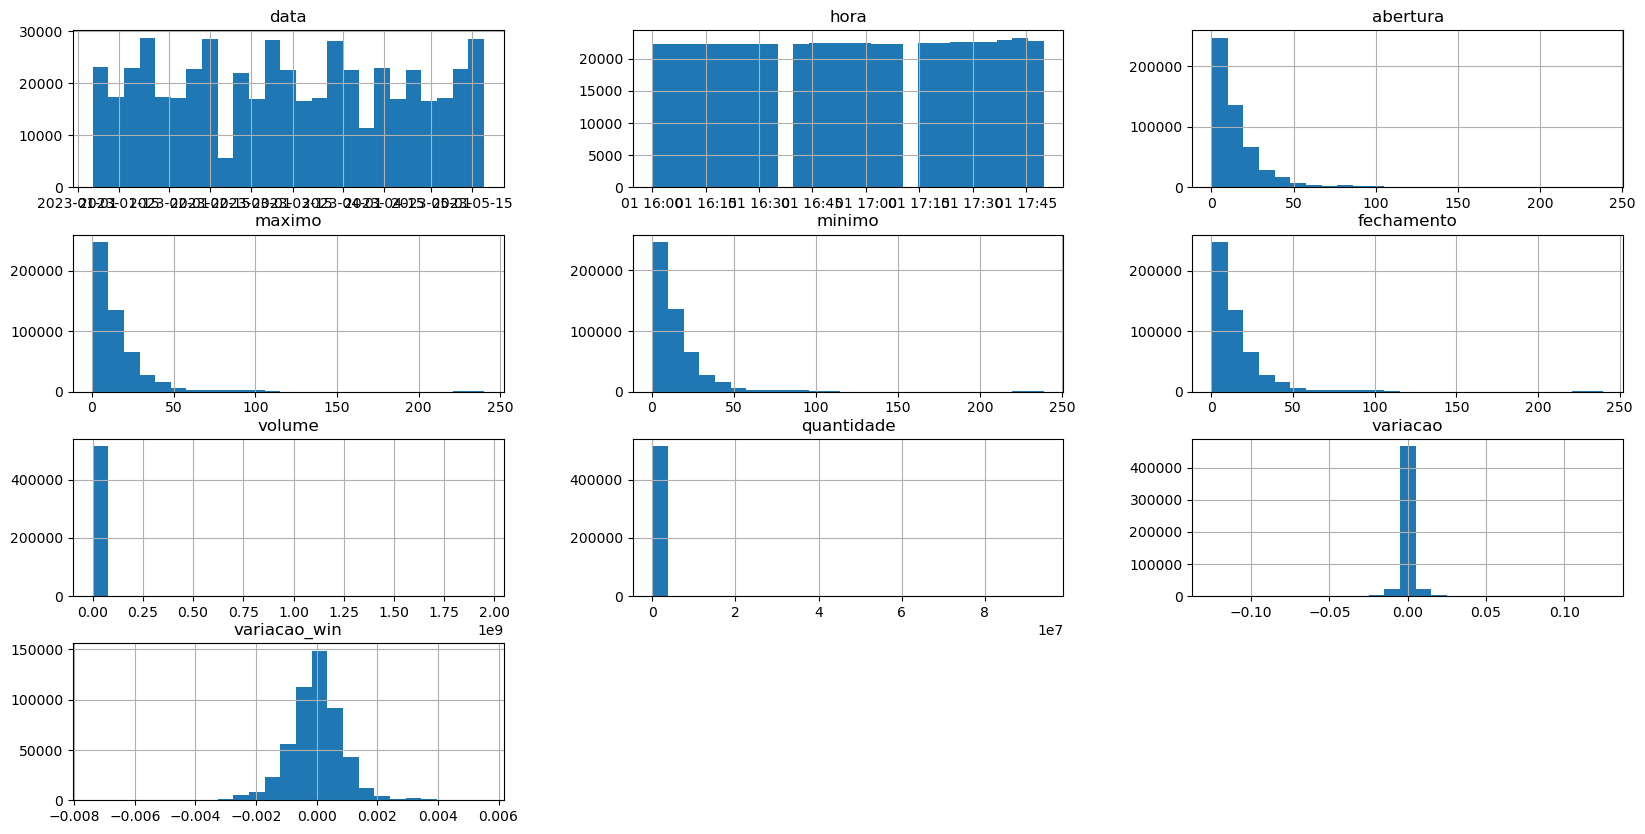

In [64]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
numerical_attributes.hist(ax = ax, bins=25);

# 4.0 Data Preparation

In [97]:
df4 = df3.copy()

In [98]:
ss = StandardScaler()

#Poisson -> abertura, maximo, minimo fechamento Usar 
df4['abertura'] = np.log(df4['abertura'])
df4['maximo'] = np.log(df4['maximo'])
df4['minimo'] = np.log(df4['minimo'])
df4['fechamento'] = np.log(df4['fechamento'])
df4['volume'] = np.log(df4['volume'])
df4['quantidade'] = np.log(df4['quantidade'])
df4['variacao'] = ss.fit_transform(df4['variacao'].values.reshape(-1,1))
df4['variacao_win'] = ss.fit_transform(df4['variacao_win'].values.reshape(-1,1))

In [99]:
df4

,ativo,data,hora,abertura,maximo,minimo,fechamento,volume,quantidade,variacao,variacao_win
0,AALR3,2023-05-19,1900-01-01 17:50:00,3.121924,3.122365,3.121042,3.122365,14.439255,4.409155,0.095831,-0.336726
1,AALR3,2023-05-19,1900-01-01 17:45:00,3.121042,3.121483,3.121042,3.121483,9.672501,6.551080,0.095922,0.294905
2,AALR3,2023-05-19,1900-01-01 17:40:00,3.121924,3.121924,3.121042,3.121483,10.029239,0.000000,-0.110551,0.878739
3,AALR3,2023-05-19,1900-01-01 17:35:00,3.120160,3.121483,3.120160,3.121483,10.670373,0.641854,0.302760,0.733330
4,AALR3,2023-05-19,1900-01-01 17:30:00,3.121924,3.122365,3.118834,3.119276,12.801279,2.772589,-0.626506,0.441511
...,...,...,...,...,...,...,...,...,...,...,...
778823,ZAMP3,2023-01-06,1900-01-01 16:20:00,1.648659,1.650580,1.646734,1.648659,9.750628,8.101678,-0.007360,-0.044377
778824,ZAMP3,2023-01-06,1900-01-01 16:15:00,1.646734,1.648659,1.644805,1.648659,9.686202,8.039157,0.443778,0.490256
778825,ZAMP3,2023-01-06,1900-01-01 16:10:00,1.642873,1.648659,1.638997,1.644805,11.094010,9.449357,0.445523,0.299389
778826,ZAMP3,2023-01-06,1900-01-01 16:05:00,1.640937,1.644805,1.640937,1.642873,9.803059,8.160518,0.446401,1.294063
